In [200]:
!nvidia-smi

Tue Sep 24 14:20:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    64W / 149W |    389MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
BATCH_SIZE = 16
NUM_EPOCHS = 5
HIDDEN_SIZE = 500
NUM_CLASSES = 10
VAL_SPLIT = 0.1

In [0]:
train_data = torchvision.datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root='./',train=False,transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

In [0]:
class CNN(nn.Module):
  def __init__(self,num_classes=NUM_CLASSES):
    super(CNN,self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc1 = nn.Sequential(nn.Linear(7*7*32,HIDDEN_SIZE),
                             nn.ReLU())
    self.fc2 = nn.Linear(HIDDEN_SIZE,NUM_CLASSES)
  
  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,7*7*32)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
model = CNN().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [64]:
total_steps = len(train_loader)
cost_train,cost_test,acc = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_train.append(loss.item())
        acc.append(correct/total)
        cost_test.append(val_loss.item())
torch.save(model.state_dict(),'model.ckpt')

Epoch:[1/5], Step:50/3750, Loss:0.821837
Test Loss:0.579352, Test Accuracy:0.7474
Epoch:[1/5], Step:100/3750, Loss:0.395628
Test Loss:0.430706, Test Accuracy:0.8536
Epoch:[1/5], Step:150/3750, Loss:0.228198
Test Loss:0.131555, Test Accuracy:0.9142
Epoch:[1/5], Step:200/3750, Loss:0.290552
Test Loss:0.067947, Test Accuracy:0.9289
Epoch:[1/5], Step:250/3750, Loss:0.100564
Test Loss:0.070955, Test Accuracy:0.9324
Epoch:[1/5], Step:300/3750, Loss:0.454642
Test Loss:0.065806, Test Accuracy:0.9331
Epoch:[1/5], Step:350/3750, Loss:0.539213
Test Loss:0.020040, Test Accuracy:0.9585
Epoch:[1/5], Step:400/3750, Loss:0.675255
Test Loss:0.012346, Test Accuracy:0.9527
Epoch:[1/5], Step:450/3750, Loss:0.031368
Test Loss:0.038658, Test Accuracy:0.9533
Epoch:[1/5], Step:500/3750, Loss:0.018134
Test Loss:0.012628, Test Accuracy:0.9597
Epoch:[1/5], Step:550/3750, Loss:0.052800
Test Loss:0.013997, Test Accuracy:0.9646
Epoch:[1/5], Step:600/3750, Loss:0.321915
Test Loss:0.004552, Test Accuracy:0.9521
Epoch

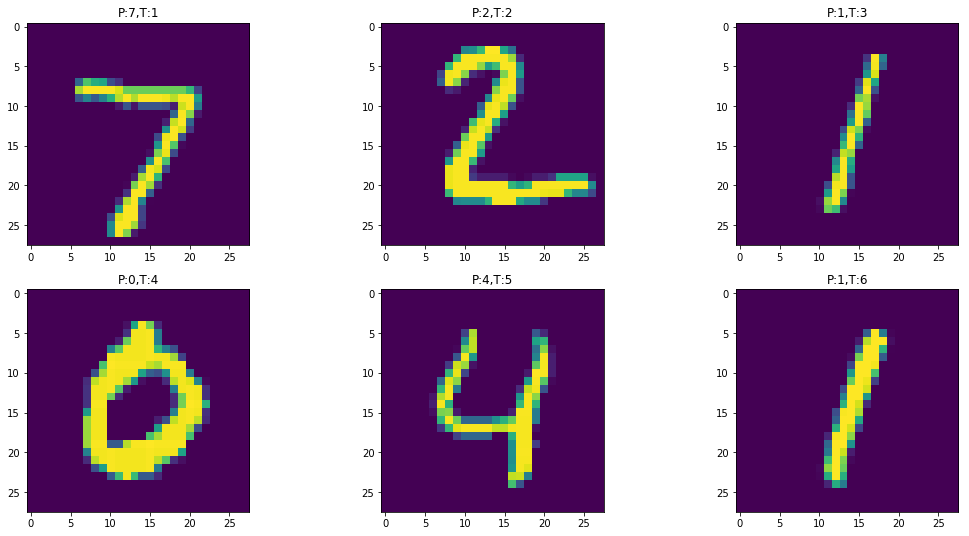

In [65]:
for img,label in test_loader:
  img = img.to(device)
  label = label.to(device)
  preds = model(img)
  fig = plt.figure(figsize=(18,9))
  fig.tight_layout()
  col,row = 3,2
  y_preds = torch.max(preds.data,1)[1].cpu().numpy()
  for i in range(1,col*row+1):
    a = fig.add_subplot(row,col,i)
    a.set_title('P:{},T:{}'.format(y_preds[i-1],labels.data[i-1]))
    plt.imshow(img[i-1,0].cpu().numpy())

  plt.show()
  break

## Using Batch Normalization

In [0]:
class CNN_BN(nn.Module):
  def __init__(self,num_classes=NUM_CLASSES):
    super(CNN_BN,self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2,stride=2))
    self.fc1 = nn.Sequential(nn.Linear(7*7*32,HIDDEN_SIZE),
                             nn.ReLU())
    self.fc2 = nn.Linear(HIDDEN_SIZE,NUM_CLASSES)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,32*7*7)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
model_bn = CNN_BN().to(device)

In [0]:
optimizer = torch.optim.Adam(model_bn.parameters())

In [69]:
total_steps = len(train_loader)
cost_train_bn,cost_test_bn,acc_bn = [],[],[]
for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_bn(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          preds = model_bn(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_test_bn.append(val_loss.item())
        acc_bn.append(correct/total)
        cost_train_bn.append(loss.item())

Epoch:[1/5], Step:50/3750, Loss:0.412143
Test Loss:0.060345, Test Accuracy:0.9265
Epoch:[1/5], Step:100/3750, Loss:0.108265
Test Loss:0.099456, Test Accuracy:0.9469
Epoch:[1/5], Step:150/3750, Loss:0.165493
Test Loss:0.012454, Test Accuracy:0.9602
Epoch:[1/5], Step:200/3750, Loss:0.066759
Test Loss:0.013487, Test Accuracy:0.9596
Epoch:[1/5], Step:250/3750, Loss:0.016204
Test Loss:0.023578, Test Accuracy:0.9572
Epoch:[1/5], Step:300/3750, Loss:0.025782
Test Loss:0.011419, Test Accuracy:0.9498
Epoch:[1/5], Step:350/3750, Loss:0.122954
Test Loss:0.001919, Test Accuracy:0.9668
Epoch:[1/5], Step:400/3750, Loss:0.012479
Test Loss:0.002124, Test Accuracy:0.9682
Epoch:[1/5], Step:450/3750, Loss:0.557327
Test Loss:0.003576, Test Accuracy:0.9700
Epoch:[1/5], Step:500/3750, Loss:0.073181
Test Loss:0.003164, Test Accuracy:0.9719
Epoch:[1/5], Step:550/3750, Loss:0.010406
Test Loss:0.000649, Test Accuracy:0.9764
Epoch:[1/5], Step:600/3750, Loss:0.043467
Test Loss:0.004530, Test Accuracy:0.9679
Epoch

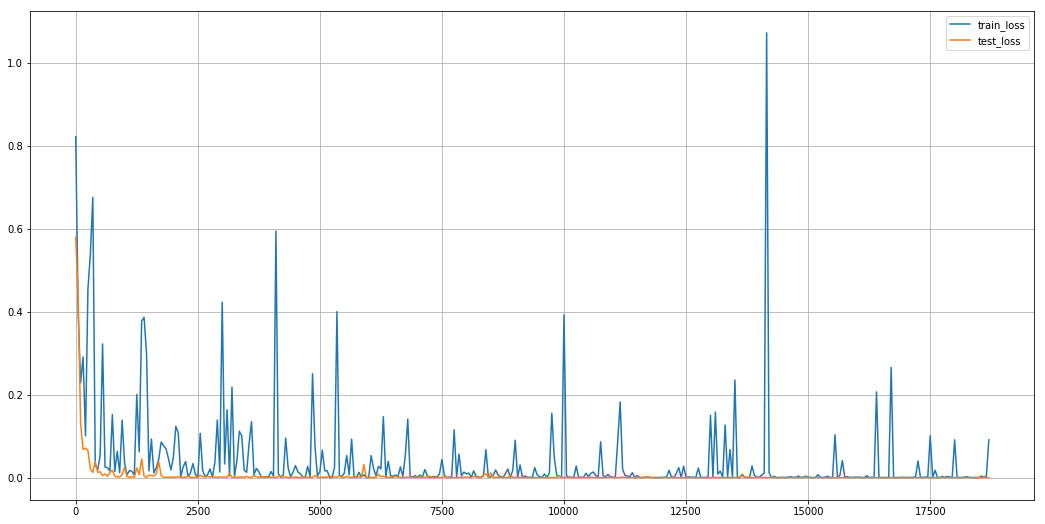

In [70]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,cost_train,label='train_loss')
plt.plot(x,cost_test,label='test_loss')
plt.legend()
plt.grid()
plt.show()

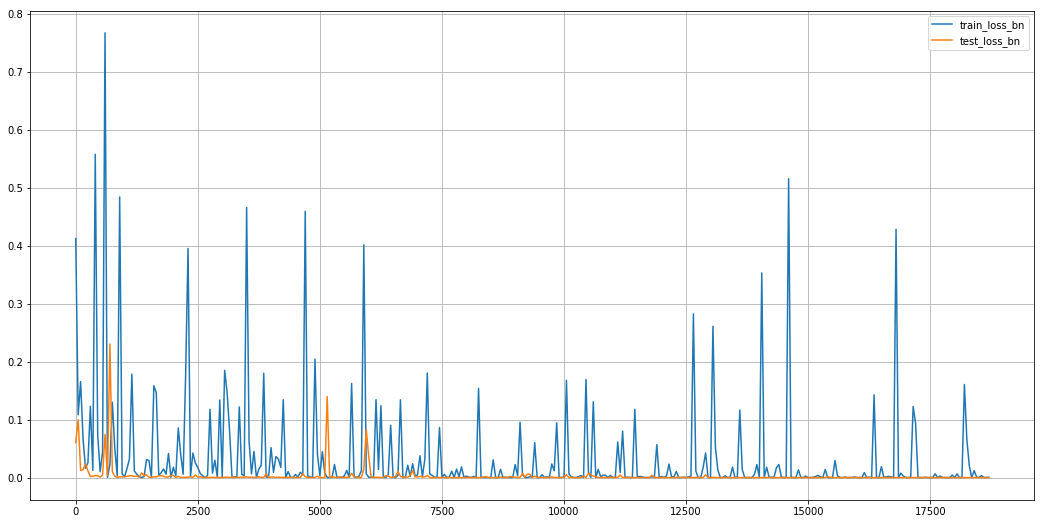

In [71]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,cost_train_bn,label='train_loss_bn')
plt.plot(x,cost_test_bn,label='test_loss_bn')
plt.legend()
plt.grid()
plt.show()

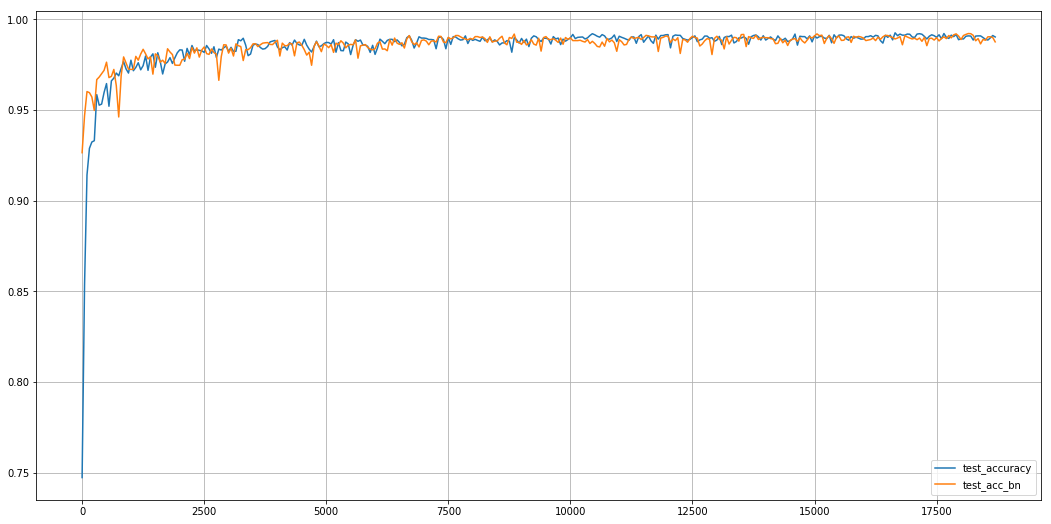

In [72]:
x = 50*np.arange(len(cost_train))
plt.figure(figsize=(18,9))
plt.plot(x,acc,label='test_accuracy')
plt.plot(x,acc_bn,label='test_acc_bn')
plt.legend()
plt.grid()
plt.show()

In [0]:
torch.save(model_bn.state_dict(),'model_bn.ckpt')

In [74]:
checkpoint = torch.load('model.ckpt')
model = CNN().to(device)
model.load_state_dict(checkpoint)
model.eval()
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

layer1.0.weight 	 torch.Size([32, 1, 3, 3])
layer1.0.bias 	 torch.Size([32])
layer2.0.weight 	 torch.Size([32, 32, 3, 3])
layer2.0.bias 	 torch.Size([32])
fc1.0.weight 	 torch.Size([500, 1568])
fc1.0.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


In [0]:
conv1_layer = model.state_dict()['layer1.0.weight'].cpu().numpy()
conv2_layer = model.state_dict()['layer2.0.weight'].cpu().numpy()

In [0]:
def normalize(x,eps=1e-8):
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    high,low = np.amax(x[i]),np.amin(x[i])
    out[i] = (x[i]-low)/(high-low+eps)
  
  out = out*255
  out = out.astype(np.uint8)
  return out

conv1_layer_normal = normalize(conv1_layer)
conv2_layer_normal = normalize(conv2_layer)

In [77]:
print(conv1_layer_normal.shape)

(32, 1, 3, 3)


In [0]:
conv1_layer_normal = conv1_layer_normal.reshape(32,3,3)

In [79]:
print(conv2_layer_normal.shape)

(32, 32, 3, 3)


## Visualizing the convolutional layer filters

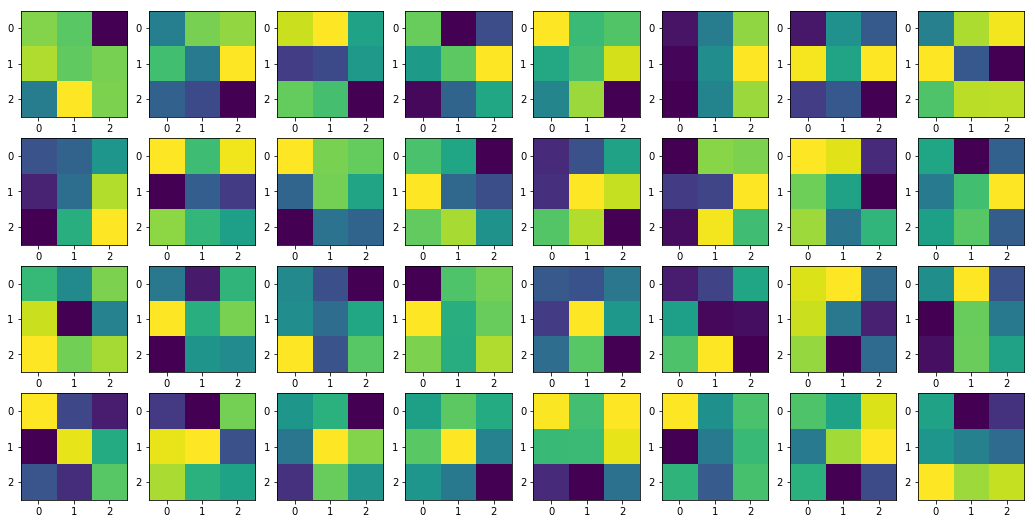

In [80]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv1_layer_normal[i-1])

plt.show()

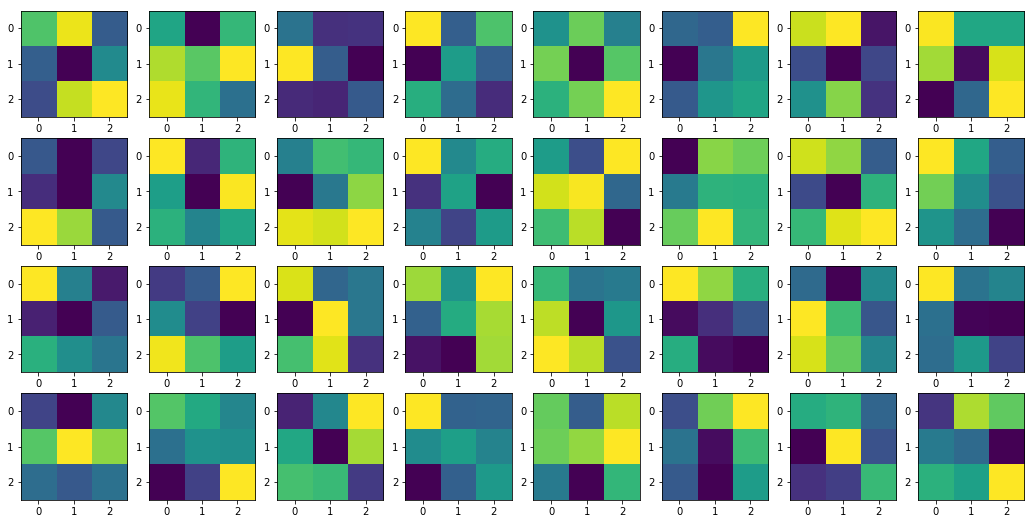

In [81]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv2_layer_normal[i-1,7])

plt.show()

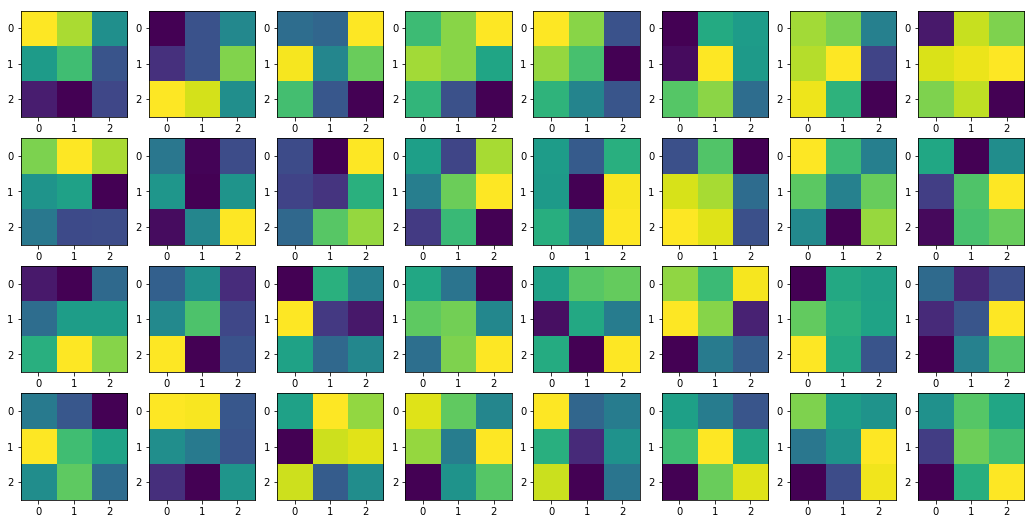

In [82]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv2_layer_normal[i-1,23])

plt.show()

## Visualizing Activation Maps

In [0]:
visualize_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=1,shuffle=False)

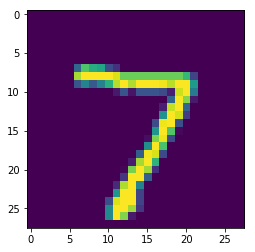

conv1 output shape: (32, 14, 14)
conv2 output shape: (32, 7, 7)


In [84]:
for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img)
  plt.show()

  layer1_out = model.layer1(images)
  layer1_out_np = layer1_out.cpu().detach().numpy().reshape(32,14,14)
  print('conv1 output shape:',layer1_out_np.shape)

  layer2_out = model.layer2(layer1_out)
  layer2_out_np = layer2_out.cpu().detach().numpy().reshape(32,7,7)
  print('conv2 output shape:',layer2_out_np.shape)

  break


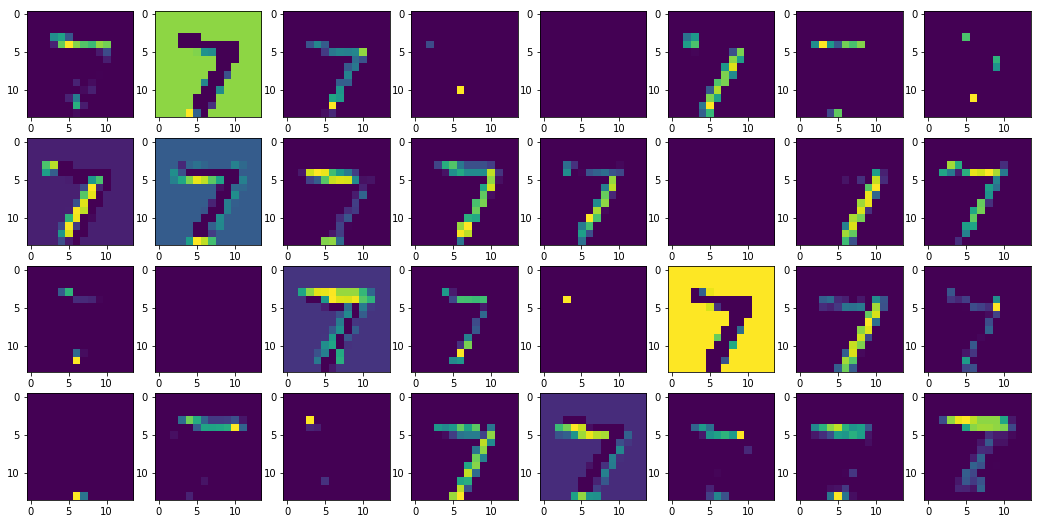

In [85]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer1_out_np[i-1])

plt.show()

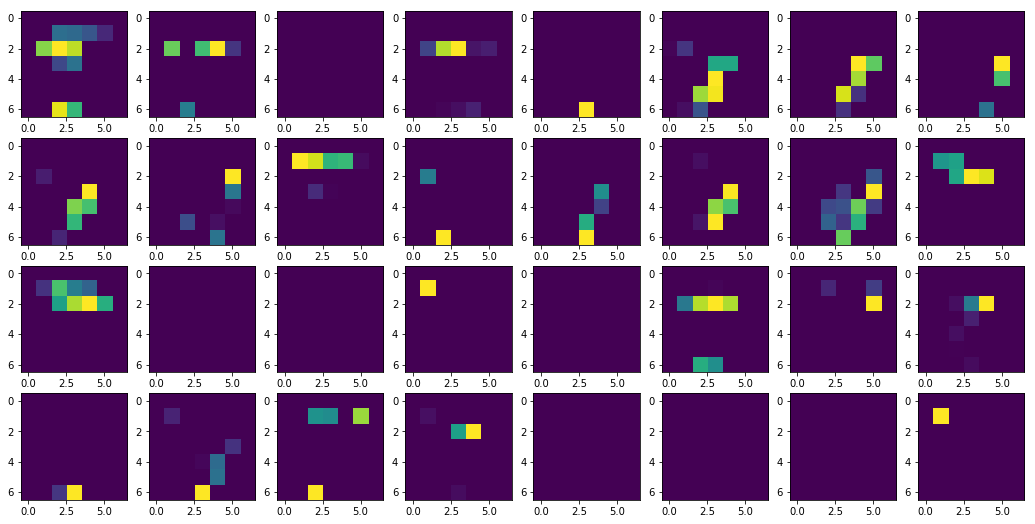

In [86]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer2_out_np[i-1])

plt.show()

## Occluding parts of the image

In [0]:
def occluded_image(x,i,j,patch_size=14):
  """
   We propose to use 16 7x7 grey patches to occlude. So, total 16 images will be generated.
  """
  y = x.copy()
  y[i:i+patch_size,j:j+patch_size] = 0.5
  return y

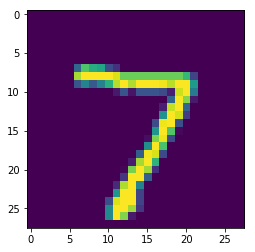

Figure:1, Actual Class:7, Probability:0.9999, Predicted:7
Figure:2, Actual Class:7, Probability:0.8688, Predicted:7
Figure:3, Actual Class:7, Probability:0.9995, Predicted:7
Figure:4, Actual Class:7, Probability:0.9973, Predicted:7
Figure:5, Actual Class:7, Probability:0.8700, Predicted:7
Figure:6, Actual Class:7, Probability:0.9999, Predicted:7
Figure:7, Actual Class:7, Probability:0.9990, Predicted:7
Figure:8, Actual Class:7, Probability:0.9868, Predicted:7
Figure:9, Actual Class:7, Probability:0.9996, Predicted:7


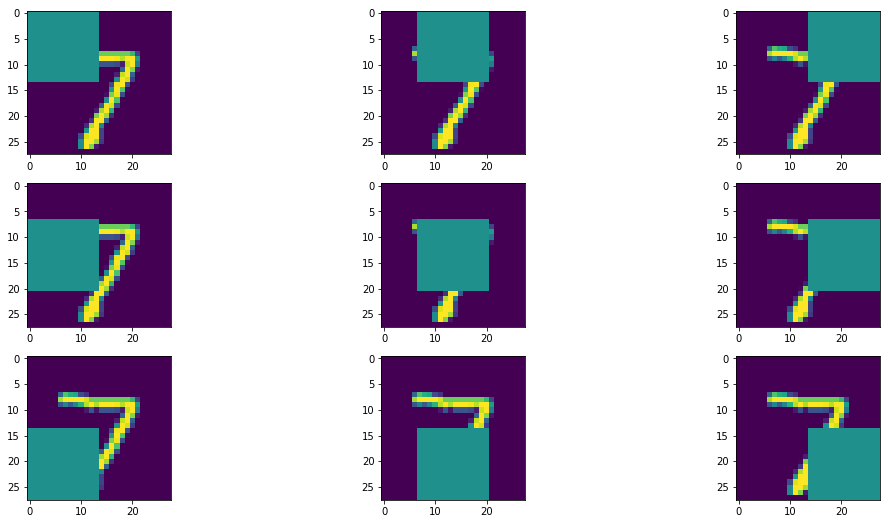

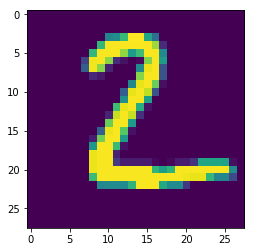

Figure:1, Actual Class:2, Probability:1.0000, Predicted:2
Figure:2, Actual Class:2, Probability:1.0000, Predicted:2
Figure:3, Actual Class:2, Probability:1.0000, Predicted:2
Figure:4, Actual Class:2, Probability:1.0000, Predicted:2
Figure:5, Actual Class:2, Probability:0.9965, Predicted:2
Figure:6, Actual Class:2, Probability:1.0000, Predicted:2
Figure:7, Actual Class:2, Probability:1.0000, Predicted:2
Figure:8, Actual Class:2, Probability:0.9995, Predicted:2
Figure:9, Actual Class:2, Probability:1.0000, Predicted:2


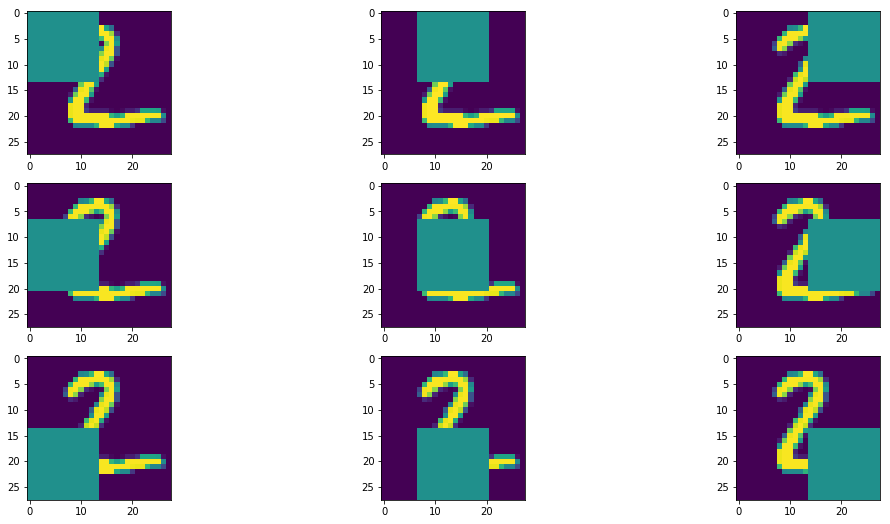

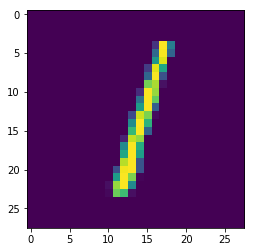

Figure:1, Actual Class:1, Probability:0.9897, Predicted:1
Figure:2, Actual Class:1, Probability:0.4978, Predicted:1
Figure:3, Actual Class:1, Probability:0.9970, Predicted:1
Figure:4, Actual Class:1, Probability:0.8110, Predicted:1
Figure:5, Actual Class:1, Probability:0.1372, Predicted:7
Figure:6, Actual Class:1, Probability:0.9880, Predicted:1
Figure:7, Actual Class:1, Probability:0.9981, Predicted:1
Figure:8, Actual Class:1, Probability:0.6757, Predicted:1
Figure:9, Actual Class:1, Probability:0.9796, Predicted:1


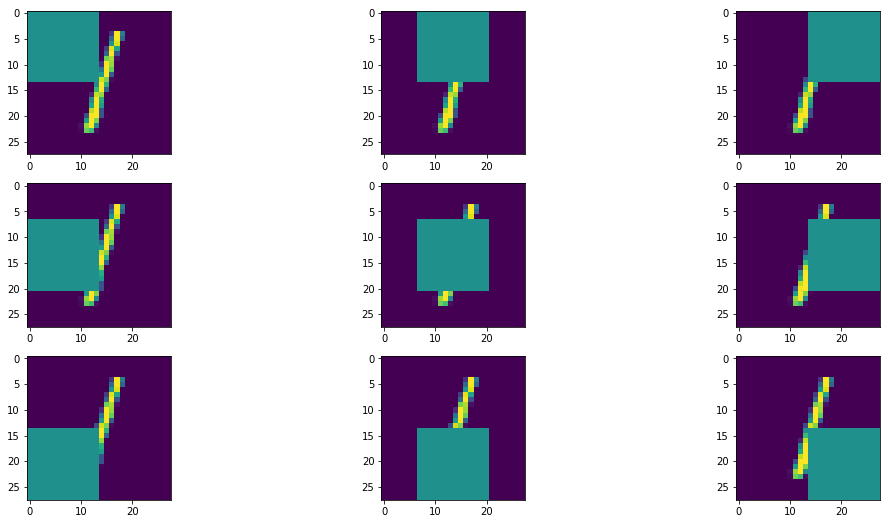

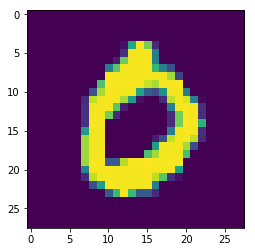

Figure:1, Actual Class:0, Probability:0.9997, Predicted:0
Figure:2, Actual Class:0, Probability:0.8305, Predicted:0
Figure:3, Actual Class:0, Probability:0.7739, Predicted:0
Figure:4, Actual Class:0, Probability:0.9862, Predicted:0
Figure:5, Actual Class:0, Probability:0.3678, Predicted:0
Figure:6, Actual Class:0, Probability:0.8550, Predicted:0
Figure:7, Actual Class:0, Probability:0.9449, Predicted:0
Figure:8, Actual Class:0, Probability:0.0605, Predicted:9
Figure:9, Actual Class:0, Probability:0.9759, Predicted:0


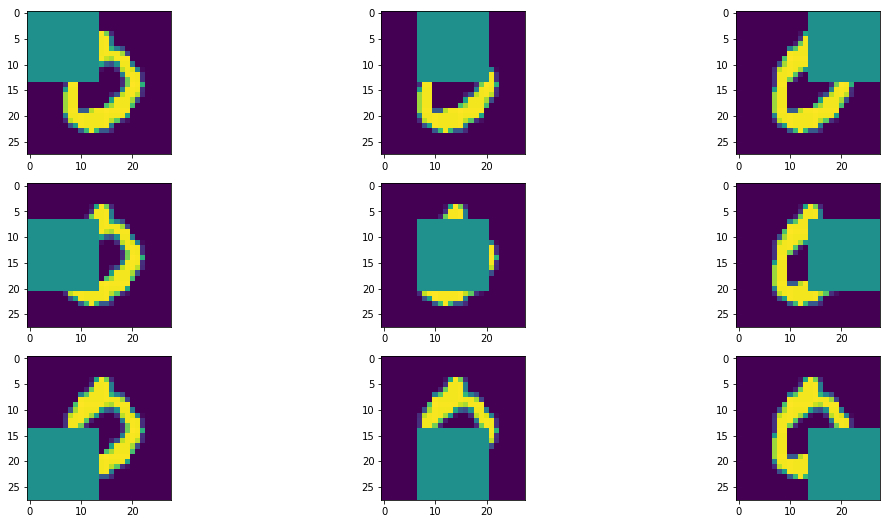

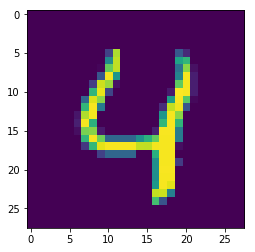

Figure:1, Actual Class:4, Probability:0.9987, Predicted:4
Figure:2, Actual Class:4, Probability:0.5754, Predicted:4
Figure:3, Actual Class:4, Probability:0.9960, Predicted:4
Figure:4, Actual Class:4, Probability:0.9998, Predicted:4
Figure:5, Actual Class:4, Probability:0.2590, Predicted:7
Figure:6, Actual Class:4, Probability:0.9641, Predicted:4
Figure:7, Actual Class:4, Probability:0.9998, Predicted:4
Figure:8, Actual Class:4, Probability:0.9997, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


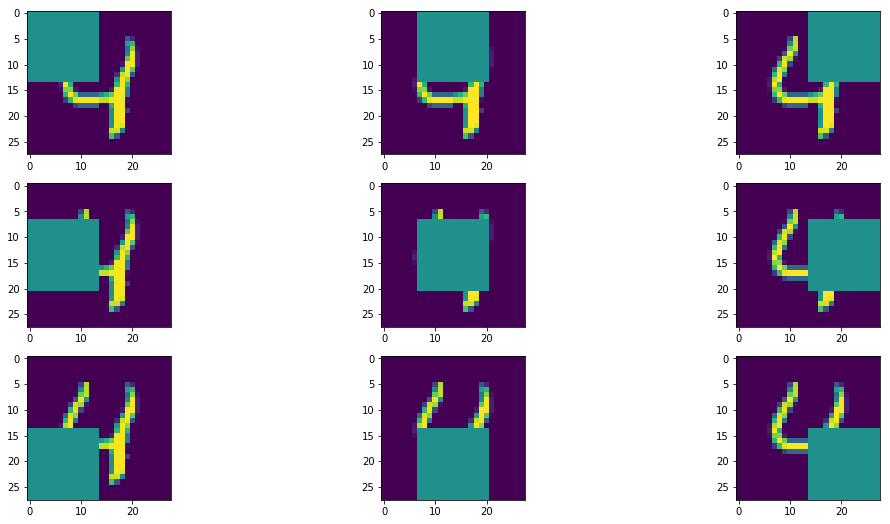

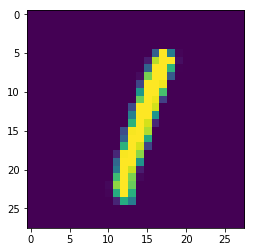

Figure:1, Actual Class:1, Probability:0.9917, Predicted:1
Figure:2, Actual Class:1, Probability:0.3581, Predicted:7
Figure:3, Actual Class:1, Probability:0.9992, Predicted:1
Figure:4, Actual Class:1, Probability:0.9905, Predicted:1
Figure:5, Actual Class:1, Probability:0.0479, Predicted:7
Figure:6, Actual Class:1, Probability:0.9839, Predicted:1
Figure:7, Actual Class:1, Probability:0.9998, Predicted:1
Figure:8, Actual Class:1, Probability:0.7885, Predicted:1
Figure:9, Actual Class:1, Probability:0.9973, Predicted:1


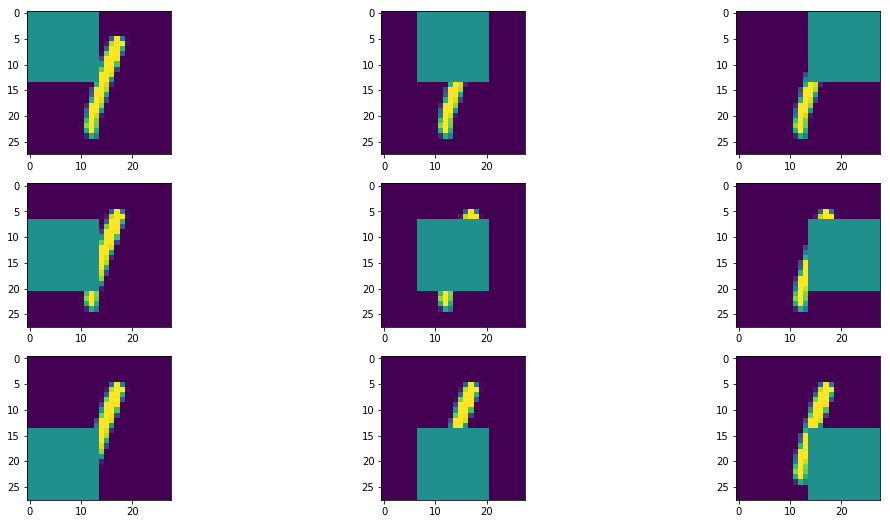

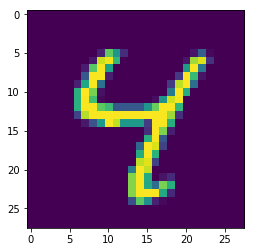

Figure:1, Actual Class:4, Probability:0.7951, Predicted:4
Figure:2, Actual Class:4, Probability:0.1792, Predicted:9
Figure:3, Actual Class:4, Probability:0.9989, Predicted:4
Figure:4, Actual Class:4, Probability:0.9156, Predicted:4
Figure:5, Actual Class:4, Probability:0.1504, Predicted:7
Figure:6, Actual Class:4, Probability:0.9914, Predicted:4
Figure:7, Actual Class:4, Probability:0.9978, Predicted:4
Figure:8, Actual Class:4, Probability:0.9999, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


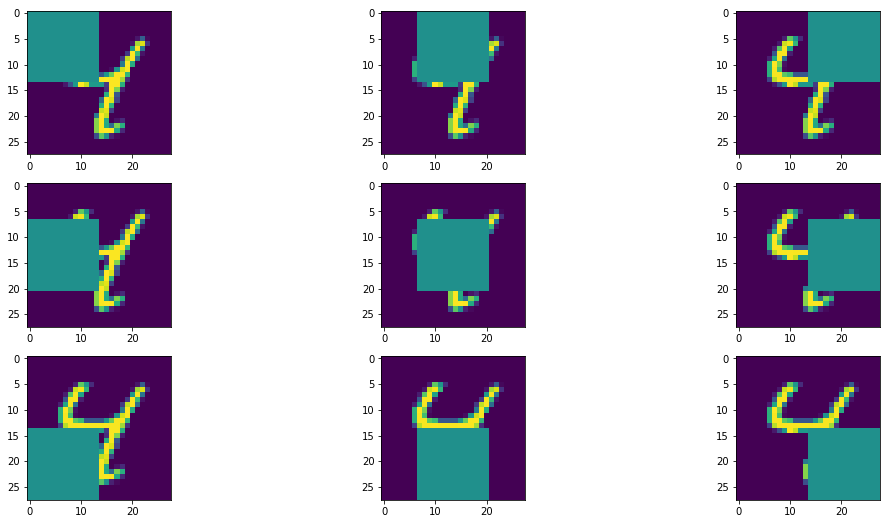

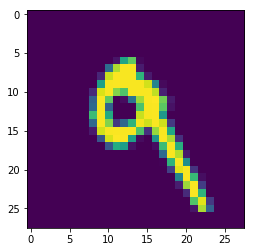

Figure:1, Actual Class:9, Probability:0.9999, Predicted:9
Figure:2, Actual Class:9, Probability:0.9094, Predicted:9
Figure:3, Actual Class:9, Probability:0.9999, Predicted:9
Figure:4, Actual Class:9, Probability:0.9162, Predicted:9
Figure:5, Actual Class:9, Probability:0.9176, Predicted:9
Figure:6, Actual Class:9, Probability:1.0000, Predicted:9
Figure:7, Actual Class:9, Probability:0.9811, Predicted:9
Figure:8, Actual Class:9, Probability:0.9813, Predicted:9
Figure:9, Actual Class:9, Probability:0.9999, Predicted:9


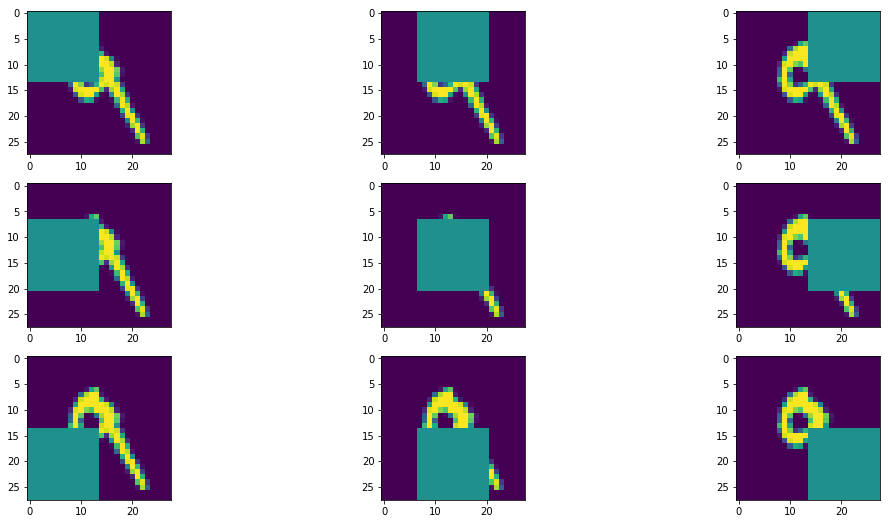

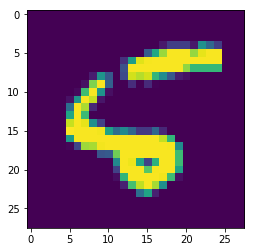

Figure:1, Actual Class:5, Probability:0.9998, Predicted:5
Figure:2, Actual Class:5, Probability:0.4220, Predicted:8
Figure:3, Actual Class:5, Probability:0.1923, Predicted:8
Figure:4, Actual Class:5, Probability:0.9997, Predicted:5
Figure:5, Actual Class:5, Probability:0.9134, Predicted:5
Figure:6, Actual Class:5, Probability:0.5948, Predicted:5
Figure:7, Actual Class:5, Probability:0.9999, Predicted:5
Figure:8, Actual Class:5, Probability:0.9851, Predicted:5
Figure:9, Actual Class:5, Probability:0.9984, Predicted:5


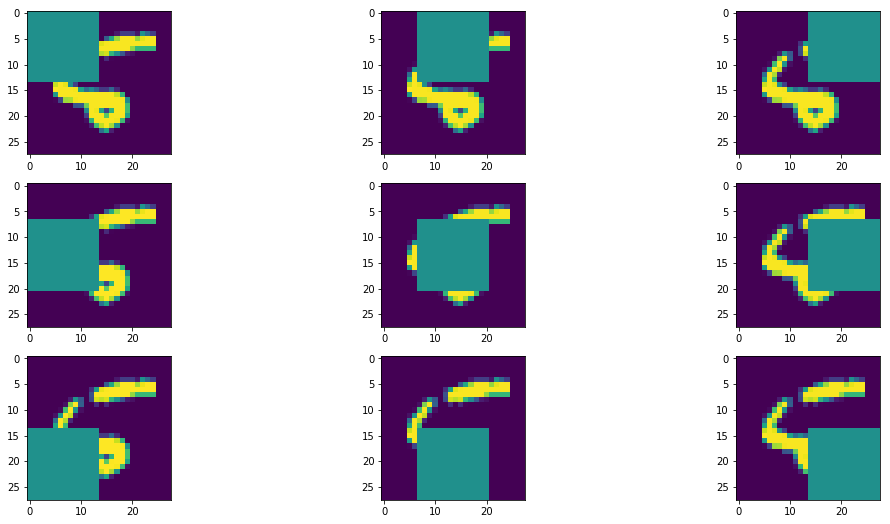

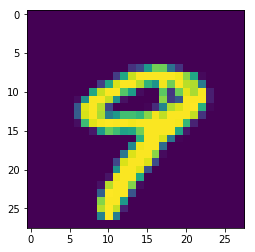

Figure:1, Actual Class:9, Probability:0.9876, Predicted:9
Figure:2, Actual Class:9, Probability:0.0013, Predicted:4
Figure:3, Actual Class:9, Probability:0.4322, Predicted:4
Figure:4, Actual Class:9, Probability:0.9932, Predicted:9
Figure:5, Actual Class:9, Probability:0.1461, Predicted:7
Figure:6, Actual Class:9, Probability:0.9978, Predicted:9
Figure:7, Actual Class:9, Probability:0.9848, Predicted:9
Figure:8, Actual Class:9, Probability:0.9781, Predicted:9
Figure:9, Actual Class:9, Probability:1.0000, Predicted:9


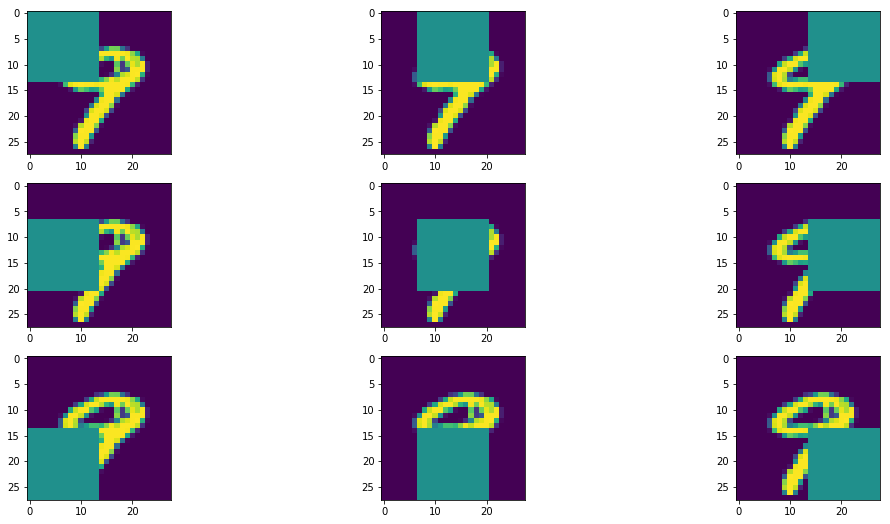

In [88]:
cnt = 0
for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img)
  plt.show()

  fig = plt.figure(figsize=(18,9))
  col,row = 3,3
  for i in range(1,10):
    fig.add_subplot(row,col,i)
    oc_image = occluded_image(img,7*int((i-1)/3),7*((i-1)%3))
    plt.imshow(oc_image)
    image = torch.from_numpy(oc_image.reshape(1,1,28,28))
    image = image.to(device)
    preds = model(image)
    for ii in labels.cpu().numpy():
      idx = ii
    
    pred_ = preds.data.cpu().numpy()
    predicted = np.argmax(pred_)
    pred_ = np.exp(pred_)/np.sum(np.exp(pred_))
    print('Figure:{}, Actual Class:{}, Probability:{:.4f}, Predicted:{}'.format(i,idx,pred_[0,idx],predicted))

  plt.show()
  cnt += 1
  if cnt == 10:
    break


# Adversarial Example
Adversarial Examples are used to fool the neural networks.
## Non-Targeted Attack

In [0]:
for child in model.children():
  for param in child.parameters():
    param.requires_grad = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Target Class:0, Iteration:0,Cost:tensor([-0.4149], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:0, Iteration:500,Cost:tensor([234.0705], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:0, Iteration:1000,Cost:tensor([1355.4526], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:0, Iteration:1500,Cost:tensor([3464.8259], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0')
Target Class:1, Iteration:0,Cost:tensor([-0.7254], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:1, Iteration:500,Cost:tensor([207.7541], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:1, Iteration:1000,Cost:tensor([1155.5747], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:1, Iteration:1500,Cost:tensor([2921.2244], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0')
Target Class:2, Iteration:0,Cost:tensor([-0.7540], device='cud

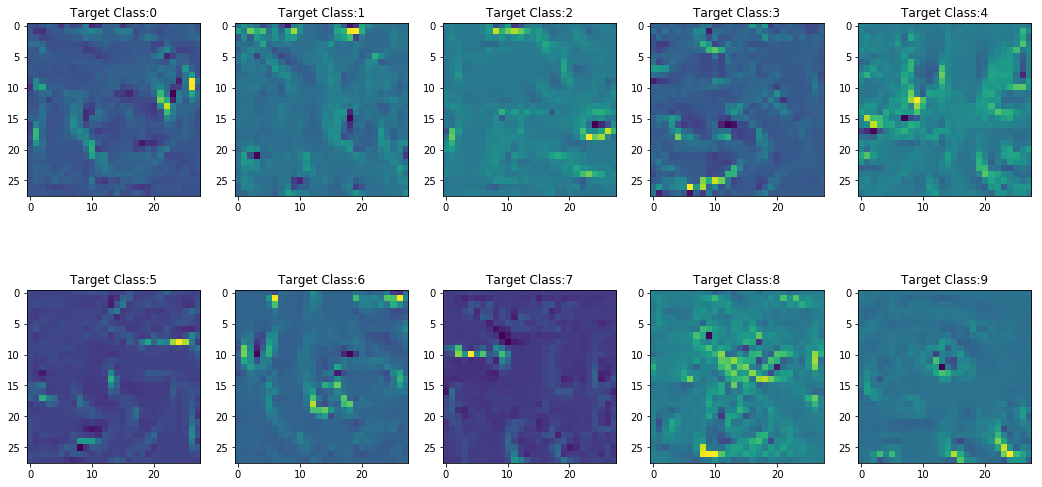

In [194]:
  img_grid = np.zeros((NUM_CLASSES,28,28))
  for i in range(NUM_CLASSES):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    for j in range(2000):
      model.zero_grad()
      out_var = model(x_var)
      loss = -out_var[0][i] 
      loss.backward()
      optimizer.step()

      if j%500 == 0:
        print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                torch.max(out_var.data,1)[1]))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)
  
  fig = plt.figure(figsize=(18,9))
  col,row = 5,2
  for i in range(1,11):
    ax = fig.add_subplot(row,col,i)
    ax.title.set_text('Target Class:{}'.format(i-1))
    plt.imshow(img_grid[i-1])
  plt.show()


## Targeted Task

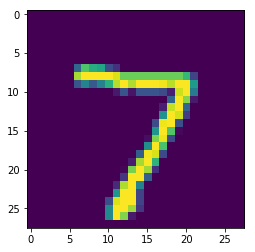

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Target Class:0, Iteration:0,Cost:tensor([-0.4029], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:500,Cost:tensor([7.5105], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:1000,Cost:tensor([2.2813], device='cuda:0'), Predicted Class:tensor([0], device='cuda:0'),Desired Class:tensor([7])
Target Class:0, Iteration:1500,Cost:tensor([0.5772], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:0,Cost:tensor([-0.6919], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:500,Cost:tensor([7.8728], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class:1, Iteration:1000,Cost:tensor([6.0409], device='cuda:0'), Predicted Class:tensor([7], device='cuda:0'),Desired Class:tensor([7])
Target Class

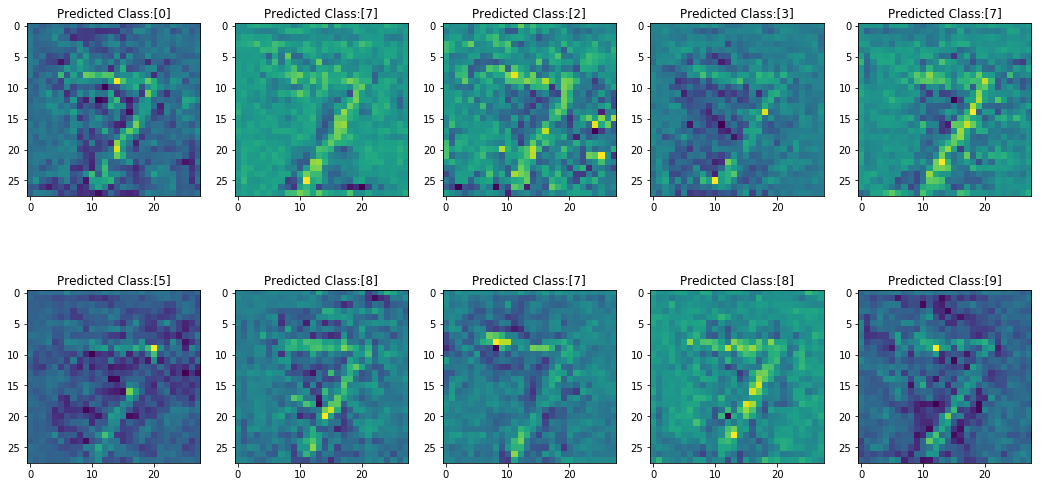

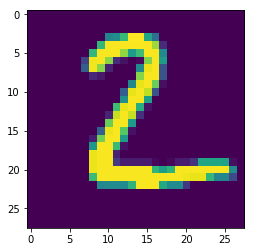

Target Class:0, Iteration:0,Cost:tensor([-0.8714], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:500,Cost:tensor([15.9894], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:1000,Cost:tensor([7.1704], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:0, Iteration:1500,Cost:tensor([3.8779], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:0,Cost:tensor([-0.5975], device='cuda:0'), Predicted Class:tensor([1], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:500,Cost:tensor([14.2422], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Class:1, Iteration:1000,Cost:tensor([14.5435], device='cuda:0'), Predicted Class:tensor([2], device='cuda:0'),Desired Class:tensor([2])
Target Cl

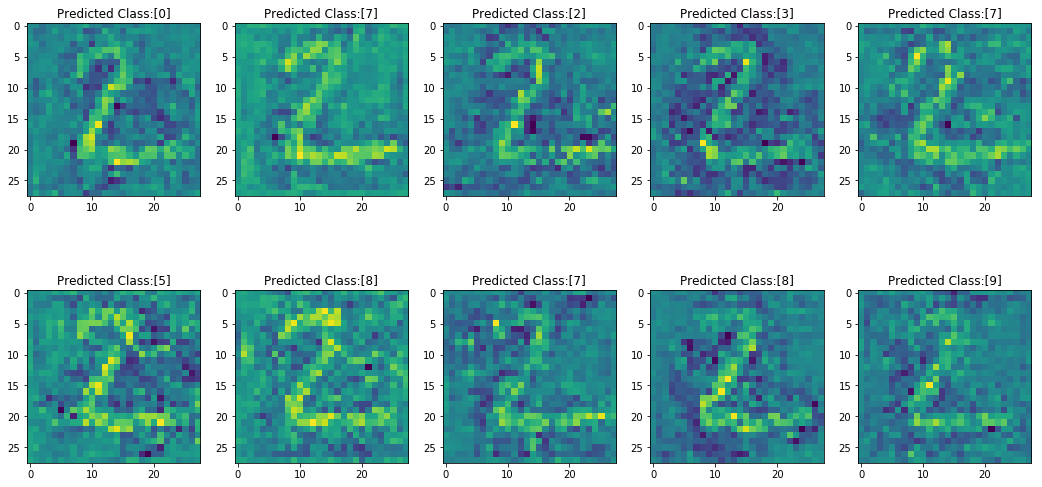

In [199]:
b = 1000
count = 0
preds = []
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  plt.imshow(img[0,0].cpu().numpy().clip(0,1))
  plt.show()
  img_grid = np.zeros((NUM_CLASSES,28,28))
  for i in range(NUM_CLASSES):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    for j in range(2000):
      model.zero_grad()
      out_var = model(x_var)
      mse_loss = nn.MSELoss()
      loss = -out_var[0][i] + b*mse_loss(x_var,img)
      loss.backward()
      optimizer.step()

      if j%500 == 0:
        print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{},Desired Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                torch.max(out_var.data,1)[1],label))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)
    z = model(x_var)
    preds.append(np.argmax(z.cpu().detach().numpy(),axis=1))
  
  fig = plt.figure(figsize=(18,9))
  col,row = 5,2
  for i in range(1,11):
    ax = fig.add_subplot(row,col,i)
    ax.title.set_text('Predicted Class:{}'.format(preds[i-1]))
    plt.imshow(img_grid[i-1])
  plt.show()

  if count == 2:
    break


## Adding Noise

In [202]:
count = 0
limit = 5
target = 7 # Put the class id for which class you want to generate. So, here we try to convert every image into 7.
o_img_grid = np.zeros((limit,28,28))
n_img_grid = np.zeros_like(o_img_grid)
n_noise_grid = np.zeros_like(o_img_grid)
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  noise = torch.zeros((1,1,28,28),requires_grad=True,device='cuda')
  optimizer = torch.optim.SGD([noise],lr=0.001)
  for j in range(1000):
    optimizer.zero_grad()
    out_var = model(img + noise)
    loss = -out_var[0][target] 
    loss.backward()
    optimizer.step()
    if j%200 == 0:
      out_var_ = out_var.cpu().detach().numpy()
      out_var_ -= np.max(out_var_)
      out_var_ = np.exp(out_var_)/np.sum(np.exp(out_var_))

      print('Iteration:{},Cost:{}, Probability of Predicted Class({}):{:.6f}, Actual Class:{}'.format(j,torch.max(out_var.data,1)[0], target,
                                                                                                 out_var_[0][target],label))
  img1 = img + noise
  o_img = img.cpu().detach().numpy()                                        
  n_img = img1.cpu().detach().numpy()
  n_noise = noise.cpu().detach().numpy()

  o_img_grid[count-1,:,:] = o_img
  n_img_grid[count-1,:,:] = n_img
  n_noise_grid[count-1,:,:] = n_noise

  if count == limit:
    break


Iteration:0,Cost:tensor([10.5514], device='cuda:0'), Probability of Predicted Class(7):0.999990, Actual Class:tensor([7])
Iteration:200,Cost:tensor([23.0174], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:400,Cost:tensor([35.0894], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:600,Cost:tensor([46.1895], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:800,Cost:tensor([57.0029], device='cuda:0'), Probability of Predicted Class(7):1.000000, Actual Class:tensor([7])
Iteration:0,Cost:tensor([20.0682], device='cuda:0'), Probability of Predicted Class(7):0.000000, Actual Class:tensor([2])
Iteration:200,Cost:tensor([11.9341], device='cuda:0'), Probability of Predicted Class(7):0.000000, Actual Class:tensor([2])
Iteration:400,Cost:tensor([5.5135], device='cuda:0'), Probability of Predicted Class(7):0.006972, Actual Class:tensor([2])
Iteration:600

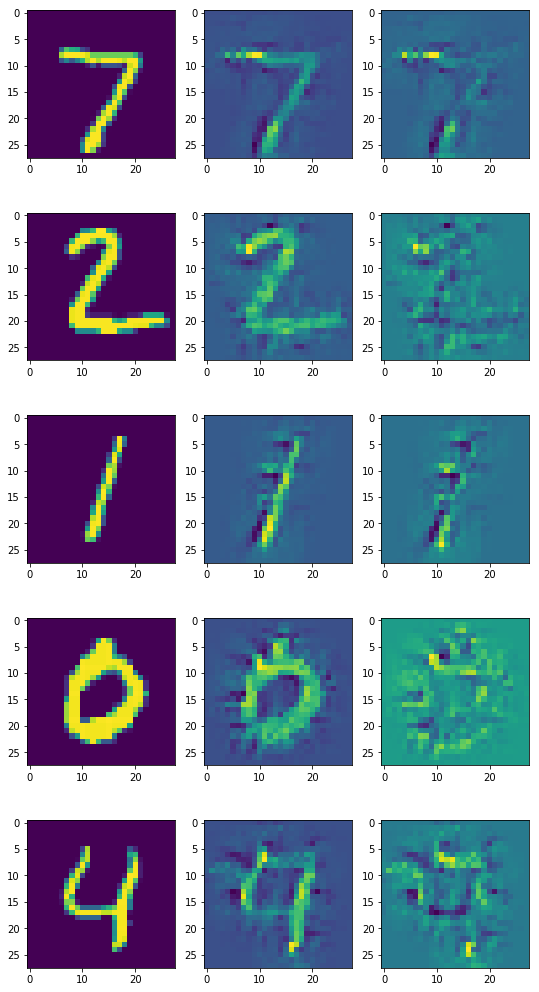

In [204]:
fig = plt.figure(figsize=(9,18))
col,row = 3,5
for i in range(1,16,3):
  ax = fig.add_subplot(row,col,i)
  plt.imshow(o_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+1)
  plt.imshow(n_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+2)
  plt.imshow(n_noise_grid[(i-1)//3])

plt.show()

In [205]:
count = 0
limit = 5
target = 4 # Put the class id for which class you want to generate. So, here we try to convert every image into 4.
o_img_grid = np.zeros((limit,28,28))
n_img_grid = np.zeros_like(o_img_grid)
n_noise_grid = np.zeros_like(o_img_grid)
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  noise = torch.zeros((1,1,28,28),requires_grad=True,device='cuda')
  optimizer = torch.optim.SGD([noise],lr=0.001)
  for j in range(1000):
    optimizer.zero_grad()
    out_var = model(img + noise)
    loss = -out_var[0][target] 
    loss.backward()
    optimizer.step()
    if j%200 == 0:
      out_var_ = out_var.cpu().detach().numpy()
      out_var_ -= np.max(out_var_)
      out_var_ = np.exp(out_var_)/np.sum(np.exp(out_var_))

      print('Iteration:{},Cost:{}, Probability of Predicted Class({}):{:.6f}, Actual Class:{}'.format(j,torch.max(out_var.data,1)[0], target,
                                                                                                 out_var_[0][target],label))
  img1 = img + noise
  o_img = img.cpu().detach().numpy()                                        
  n_img = img1.cpu().detach().numpy()
  n_noise = noise.cpu().detach().numpy()

  o_img_grid[count-1,:,:] = o_img
  n_img_grid[count-1,:,:] = n_img
  n_noise_grid[count-1,:,:] = n_noise
      
  if count == limit:
    break


Iteration:0,Cost:tensor([10.5514], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([7])
Iteration:200,Cost:tensor([6.5153], device='cuda:0'), Probability of Predicted Class(4):0.000011, Actual Class:tensor([7])
Iteration:400,Cost:tensor([4.3690], device='cuda:0'), Probability of Predicted Class(4):0.001971, Actual Class:tensor([7])
Iteration:600,Cost:tensor([3.8163], device='cuda:0'), Probability of Predicted Class(4):0.031617, Actual Class:tensor([7])
Iteration:800,Cost:tensor([4.2117], device='cuda:0'), Probability of Predicted Class(4):0.114571, Actual Class:tensor([7])
Iteration:0,Cost:tensor([20.0682], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([2])
Iteration:200,Cost:tensor([12.9975], device='cuda:0'), Probability of Predicted Class(4):0.000000, Actual Class:tensor([2])
Iteration:400,Cost:tensor([8.5462], device='cuda:0'), Probability of Predicted Class(4):0.000013, Actual Class:tensor([2])
Iteration:600,Cos

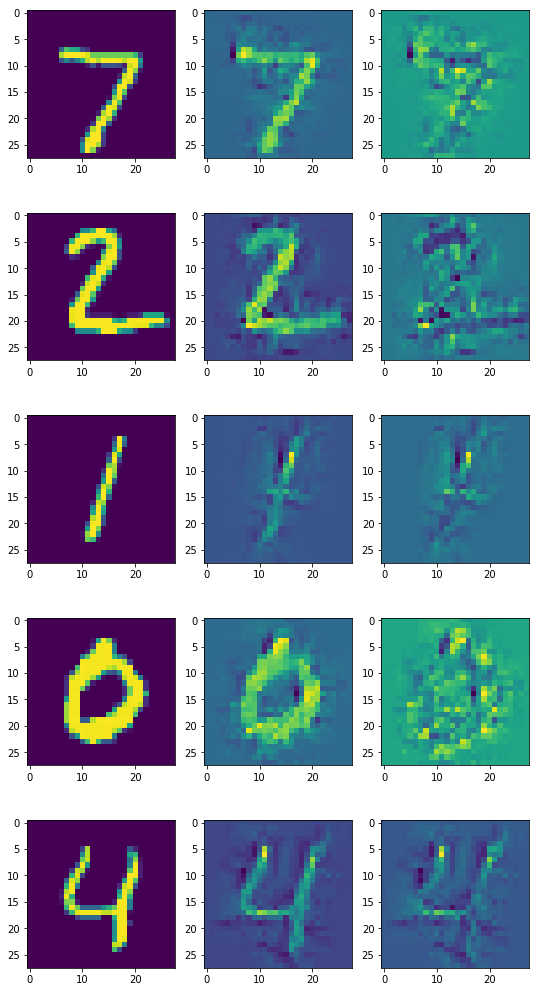

In [207]:
fig = plt.figure(figsize=(9,18))
col,row = 3,5
for i in range(1,16,3):
  ax = fig.add_subplot(row,col,i)
  plt.imshow(o_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+1)
  plt.imshow(n_img_grid[(i-1)//3])

  ax = fig.add_subplot(row,col,i+2)
  plt.imshow(n_noise_grid[(i-1)//3])

plt.show()

In [0]:
cnt = 0
limit = 10
img_grid = np.zeros((limit,28,28))
noise_image_grid = np.zeros_like(img_grid)
true_class = []
pred_class = []
for image,label in visualize_loader:
  cnt += 1
  if cnt < limit:
    continue
  else:
    image = image.to(device)
    label = label.to(device)
    img_grid[cnt-limit,:,:] = image.cpu().numpy().reshape(28,28)  
    real_preds = model(image)

    # Pick any random noise. This is the noise added to make a 1 look like 4.
    add_noise = torch.from_numpy(np.asarray(n_noise_grid[2],dtype=np.float32)).to(device) 

    noisy_image = image + add_noise
    noise_image_grid[cnt-limit,:,:] = noisy_image.cpu().numpy().reshape(28,28)

    noisy_preds = model(noisy_image)
    true_class.append(np.argmax(real_preds.cpu().numpy(),axis=1))
    pred_class.append(np.argmax(noisy_preds.cpu().numpy(),axis=1))
  if cnt == 2*limit-1:
    break

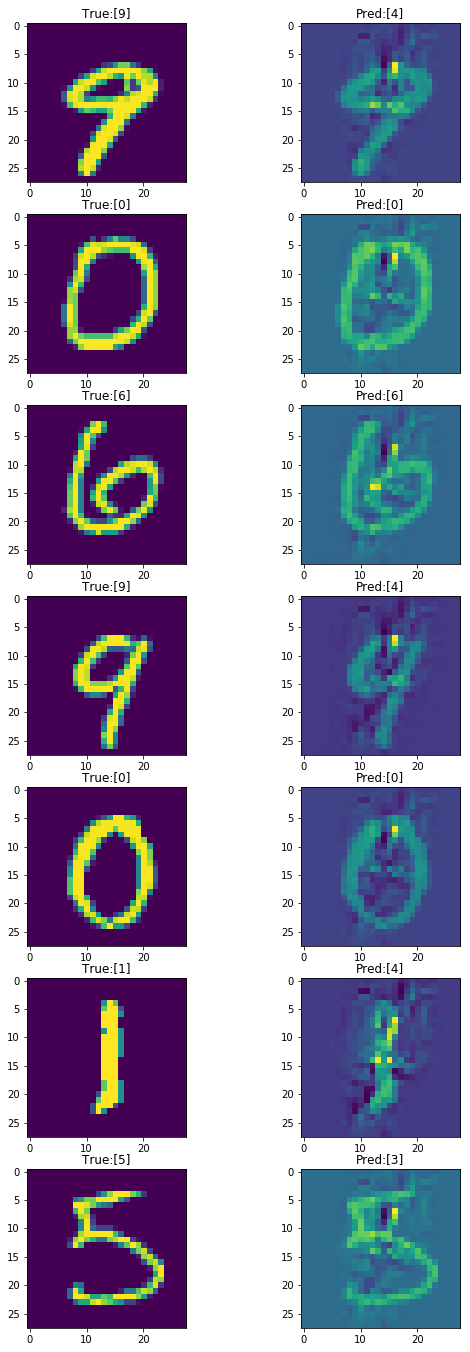

In [219]:
fig = plt.figure(figsize=(9,24))
col,row = 2,7
for i in range(1,15,2):
  ax = fig.add_subplot(row,col,i)
  ax.title.set_text('True:{}'.format(true_class[(i-1)//2]))
  plt.imshow(img_grid[(i-1)//2])

  ax = fig.add_subplot(row,col,i+1)
  ax.title.set_text('Pred:{}'.format(pred_class[(i-1)//2]))
  plt.imshow(noise_image_grid[(i-1)//2])

plt.show()